In [54]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

### Load session and complete climb data

In [55]:
sessions = pd.read_csv('raw_data/5513-climb-session-export-2024-02-17T22-15-04.csv')
climbs = pd.read_csv('raw_data/5513-climb-export-2024-02-17T22-15-04.csv')

In [56]:
climbs.head()

,Session ID,Time,Discipline,Level,Attempt,Grade System
0,7.297506e+08,2024-02-15 20:31:59,Boulder,V0,False,hueco
1,7.297506e+08,2024-02-15 20:32:54,Boulder,V0,False,hueco
2,7.297506e+08,2024-02-15 20:32:56,Boulder,V1,False,hueco
3,7.297506e+08,2024-02-15 20:34:11,Boulder,V2,False,hueco
4,7.297506e+08,2024-02-15 20:35:21,Boulder,V1,False,hueco


### Progress per bouldering grade

/var/folders/bw/pbfwt2p16s729kbshjt5y7900000gr/T/ipykernel_69309/296094869.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Time'] = pd.to_datetime(filtered_df['Time'])
/Users/adminalba/anaconda3/envs/pinnacle/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/adminalba/anaconda3/envs/pinnacle/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf

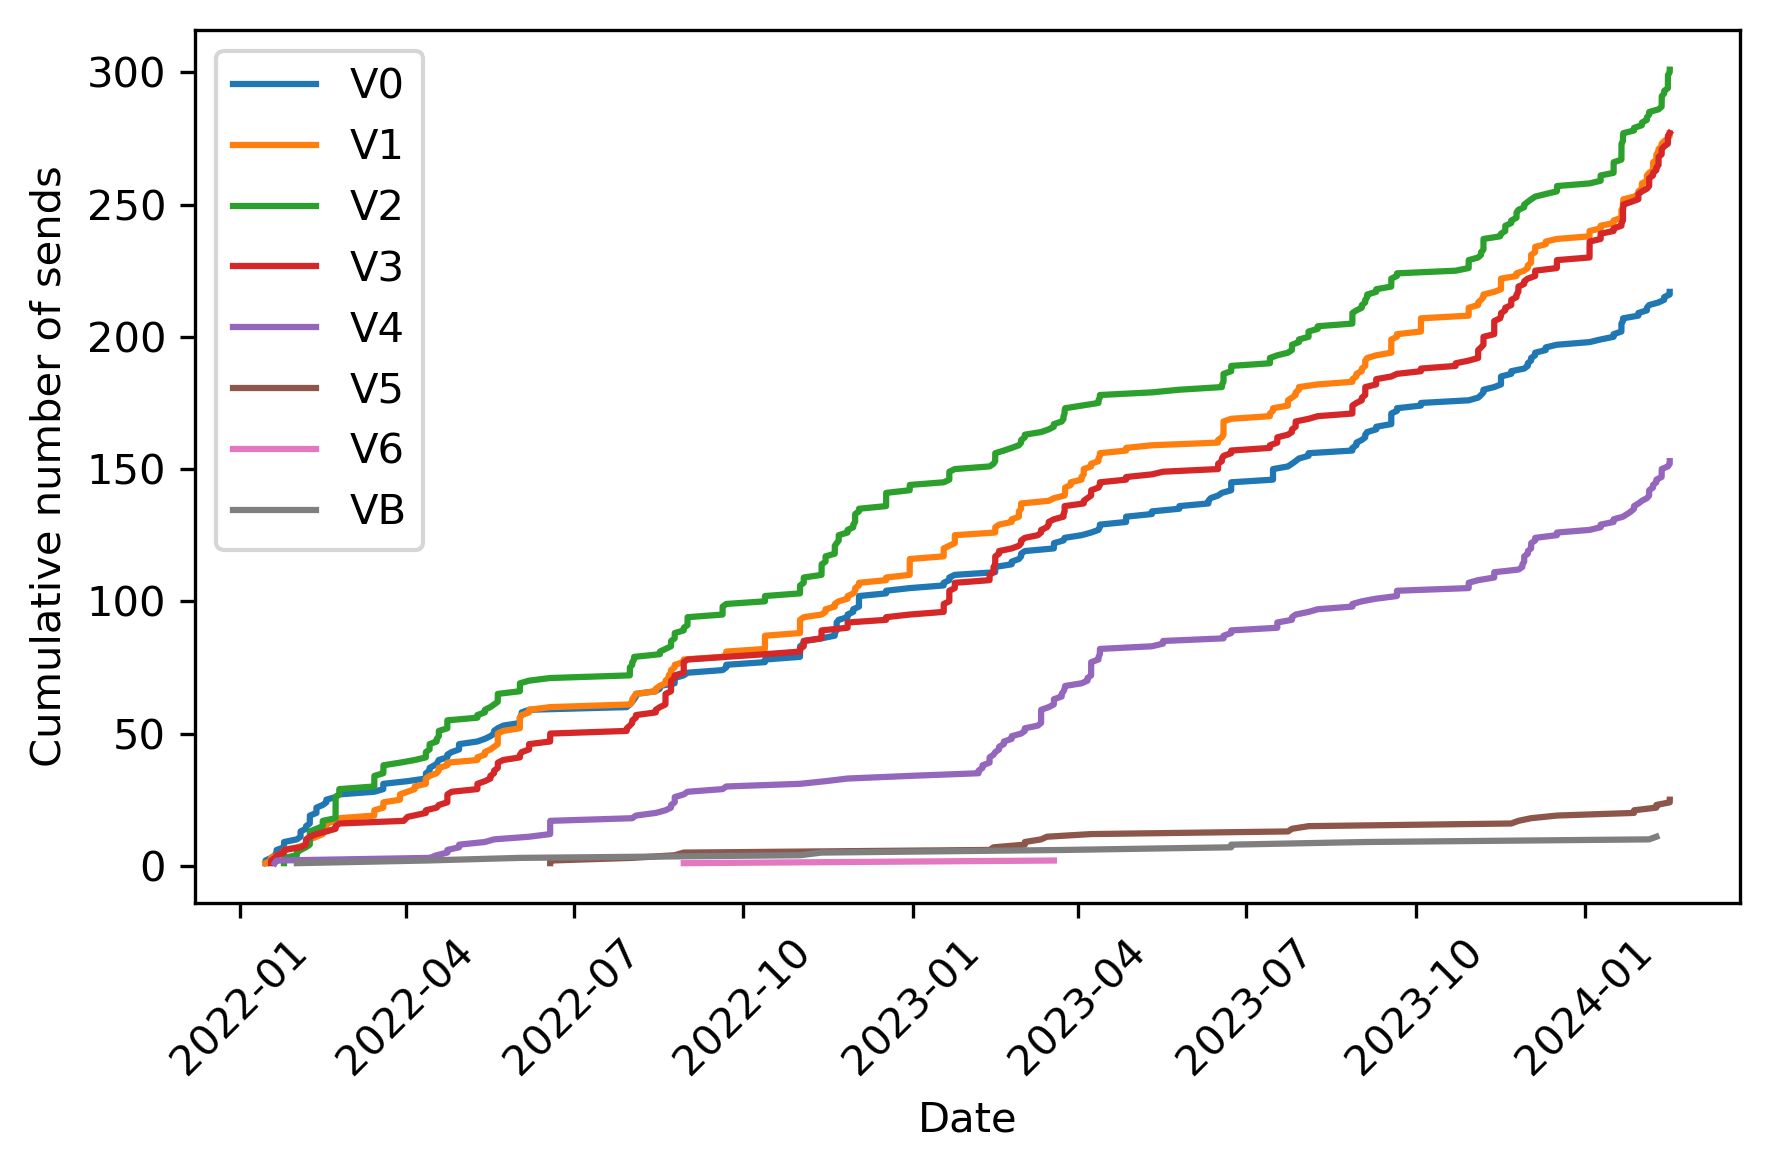

In [57]:
# subset bouldering data only 
boulders = climbs[climbs['Discipline'] == 'Boulder']
grouped_levels = {}
for level, group in boulders.groupby('Level'):
    grouped_levels[level] = group

sends = {}
for level, group_df in grouped_levels.items():
    sends[level] = group_df[group_df['Attempt'] == False]

plt.figure(figsize=(6, 4),dpi=300)
chosen_palette = sns.color_palette("rocket")

for level, filtered_df in sends.items():
    filtered_df['Time'] = pd.to_datetime(filtered_df['Time'])  
    filtered_df = filtered_df.sort_values(by='Time')  # Sort DataFrame by date
    filtered_df['Cumulative'] = range(1, len(filtered_df) + 1)  # Calculate cumulative count of rows
    sns.lineplot(x='Time', y='Cumulative', data=filtered_df,label=level)
    plt.xlabel('Date')
    plt.ylabel('Cumulative number of sends')
    plt.xticks(rotation=45)

plt.legend()
plt.tight_layout()
plt.show()

/var/folders/bw/pbfwt2p16s729kbshjt5y7900000gr/T/ipykernel_69309/1030052350.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Time'] = pd.to_datetime(filtered_df['Time'])
/Users/adminalba/anaconda3/envs/pinnacle/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/adminalba/anaconda3/envs/pinnacle/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf

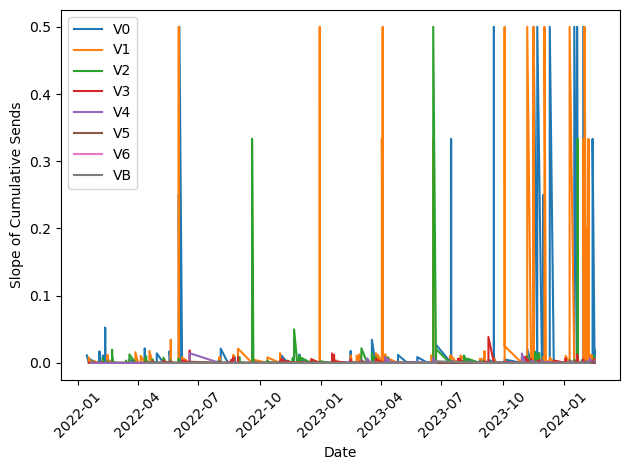

In [63]:
for level, filtered_df in sends.items():
    filtered_df['Time'] = pd.to_datetime(filtered_df['Time'])
    filtered_df = filtered_df.sort_values(by='Time')  # Sort DataFrame by date
    filtered_df['Cumulative'] = np.arange(1, len(filtered_df) + 1) 
    filtered_df['Slope'] = filtered_df['Cumulative'].diff() / pd.to_numeric(filtered_df['Time'].diff().dt.total_seconds()) 
    
    sns.lineplot(x='Time', y='Slope', data=filtered_df, label=level)
    plt.xlabel('Date')
    plt.ylabel('Rate of change of cumulative sends')
    plt.xticks(rotation=45)

plt.legend()
plt.tight_layout()
plt.show()
